In [53]:
from fenics import *
import sys
sys.path.append('../data/')
sys.path.append('../graphnics/')
sys.path.append('../applications/')
sys.path.append('../../NetworkGen/')
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import imp
from graphnics import *

# graphnics demo

`graphnics` (in development) is a python library that combines `networkx` and `FEniCS`. The module provides functionality for meshing and assembling variational forms on network structures.

The central datastructure facilitating this is the `FenicsGraph` class, which inherits from the `DiGraph` (directed graph) in `networkx`.

`graphnics` contains convenience function for making commonly used graphs:

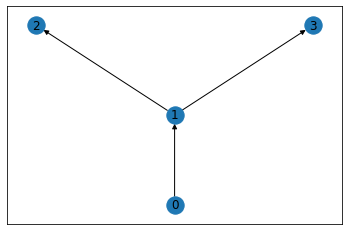

In [6]:
# The hello world of graphs: A simple bifurcation
G = make_Y_bifurcation()

pos = nx.get_node_attributes(G, 'pos') # dict with node positions
nx.draw_networkx(G, pos)

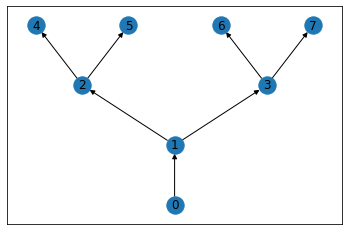

In [7]:
# Getting a bit more fancy: A double bifurcation
G = make_double_Y_bifurcation()

pos = nx.get_node_attributes(G, 'pos') # dict with node positions
nx.draw_networkx(G, pos)

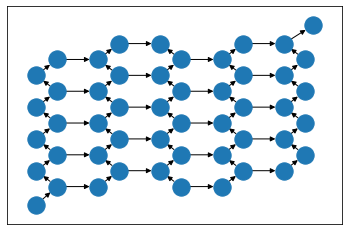

In [81]:
# Pial networks are known to look like honeycomb networks
G = honeycomb(4,4)

pos = nx.get_node_attributes(G, 'pos') # dict with node positions
nx.draw_networkx(G, pos, with_labels=False)

## Meshing the domain

Before we can solve flow equations on these networks we need to mesh the domain. Let $\mathsf{G}=(\mathsf{V},\mathsf{E})$ denote a graph with edges $\mathsf{E}=(v_j, v_k)$ and vertices $\mathsf{V}$. Each edge $e_i = (v_j, v_k) \in \mathsf{E}$ is associated with a centerline $\Lambda_i$ going between the coordinate associated with the points $v_j$ and $v_k$. 

Let $\Lambda = \cup_{i=1^n} \Lambda_i$ denote the global mesh. We can construct a fenics mesh for $\Lambda$ by running

Text(0.5, 1.0, 'Vertices in our global mesh')

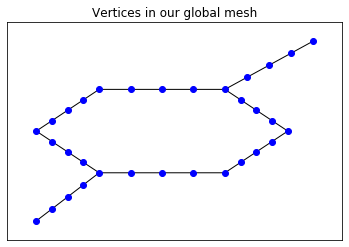

In [37]:
G = honeycomb(1,1)
G.make_mesh(n=2)

c = G.global_mesh.coordinates()
plt.plot(c[:,0], c[:,1], 'bo')
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos, node_size=0, arrowsize=1e-3, with_labels=False)
plt.title('Vertices in our global mesh')

Running `G.make_mesh(n=3)` creates a global mesh with 3 mesh refinements. The mesh generator also creates submeshes associated with each edge of the graph, and meshfunctions containing e.g. information on bifurcation points and boundary points.

## Solving 1d network problems



Let's say we want to solve the hydraulic network model
\begin{align*}
\mathcal{R} Q + \partial_s P &= 0 & \text{ in } \Lambda \\
\partial_s Q &= 0 & \text{ in } \Lambda
\end{align*}
where $P$ is the pressure, $Q$ is the cross-section flux and $\mathcal{R}$ is the resistance.

Eliminating the flux yields a network Laplacian equation
\begin{align*}
\partial_{ss} P &= 0 & \text{ in } \Lambda.
\end{align*}


Discretizing with $\mathbb{P}^1$-elements assures us that the pressure is continuous across bifurcation points, which is what we want physically. 

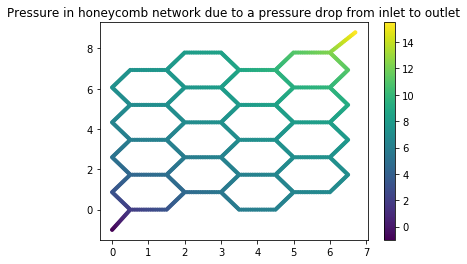

In [82]:
G = honeycomb(4,4)
G.make_mesh(n=4)

V = FunctionSpace(G.global_mesh, 'CG', 1)
p = TrialFunction(V)
v = TestFunction(V)

R = Constant(0.1) # network resistance

a = inner(grad(p), grad(v))*dx
L = Constant(0)*v*dx

p_bc = Expression('x[0]+x[1]', degree=2)
bc = DirichletBC(V, p_bc, 'on_boundary')

sol = Function(V)
solve(a==L, sol, bc)

c = V.tabulate_dof_coordinates()
sol.vector().get_local()
cmap  = plt.scatter(c[:,0], c[:,1], s=10, c=sol.vector().get_local())
plt.title('Pressure in honeycomb network due to a pressure drop from inlet to outlet')
plt.colorbar()

## Solving more complicated 1d network problems

If the governing equations can not be collapsed to a primal formulation (i.e. one equation involving the pressure as the only variable), the system becomes more complicated to assemble and solve. 

Let's say we want to solve the steady-state Stokes model
\begin{align*}
\mathcal{R} Q + A^{-1} \partial_{ss} Q + \partial_s P &= 0 & \text{ in } \Lambda_{i} \\
\partial_s Q &= 0 & \text{ in } \Lambda_{i}
\end{align*}
where $P$ is the pressure and $Q$ is the cross-section flux, $\mathcal{R}$ is the resistance and $A$ is the cross-section area of the network.

This model is solved using the `NetworkStokes` model in `flowmodels.py`.

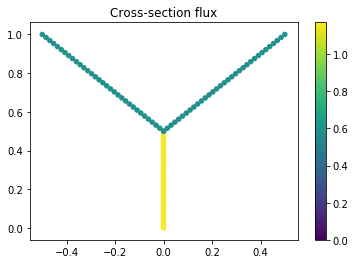

In [83]:
G = make_Y_bifurcation()
G.make_mesh(n=4)

for e in G.edges():
    G.edges()[e]['Res'] = 1
    G.edges()[e]['Ainv'] = 1

model = NetworkStokes(G, p_bc = Expression('x[1]', degree=2))

W = model.W
a = model.a_form()
L = model.L_form()

A, b = map(ii_assemble, (a,L))
A, b = map(ii_convert, (A,b))

qp = ii_Function(W)
solver = LUSolver(A, 'mumps')
solver.solve(qp.vector(), b)

q_p = qp[0]  # parent vessel flux
q_d1 = qp[1] # daughter vessel flux
q_d2 = qp[2] # other daughter vessel flux
p = qp[3] # global pressure

max_flux = np.max([np.max(func.vector().get_local()) for func in [q_p, q_d1, q_d2]])

for sol in qp[:3]:
    c = sol.function_space().tabulate_dof_coordinates()
    cmap  = plt.scatter(c[:,0], c[:,1], s=20, c=sol.vector().get_local(), vmin=0, vmax=max_flux)
plt.title('Cross-section flux')
plt.colorbar()

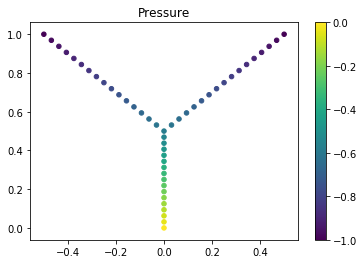

In [84]:
sol = qp[G.num_edges]
c = sol.function_space().tabulate_dof_coordinates()
cmap  = plt.scatter(c[:,0], c[:,1], s=20, c=sol.vector().get_local())
plt.title('Pressure')
plt.colorbar()

## Extensions to mixed-dimensional problems

The assemble of the bilinear form uses the block structure `fenics_ii`. Thus it should be straightforward to move to mixed-dimensional problems. To this end one could combine the code presented here with the [coupled 1d-3d demo](https://github.com/MiroK/fenics_ii/blob/master/demo/daq_3d1d.py) in `fenics_ii`.

